In [76]:
import importlib
import warnings
import common_func as cf
import asyncio
importlib.reload(cf)
warnings.filterwarnings('ignore')

In [77]:
class ShortStrangle(cf.TradingStrategy):
    def __init__(self, loader: cf.DataLoader, asset_name):
        cf.TradingStrategy.__init__(self, loader, asset_name, 2)

    def _get_option_count(self):
        return 2

    def _get_strategy_delta(self, calls:list, puts: list) -> float:
        return calls[1]['Delta'] + puts[1]['Delta']

    def _is_strategy_valid(self, calls:list, puts: list) -> bool:
        return calls[1]['Strike'] > puts[1]['Strike']

    def _short_portfolio(self, calls:list, puts: list):
        return [calls[1], puts[1]]

    def _long_portfolio(self, calls:list, puts: list):
        return []

class ShortStrangle2(cf.TradingStrategy):
    def __init__(self, loader: cf.DataLoader, asset_name):
        cf.TradingStrategy.__init__(self, loader, asset_name, 2)

    def _get_option_count(self):
        return 2

    def _get_strategy_delta(self, calls:list, puts: list) -> float:
        return calls[0]['Delta'] + puts[1]['Delta']

    def _is_strategy_valid(self, calls:list, puts: list) -> bool:
        return calls[0]['Strike'] > puts[1]['Strike']

    def _short_portfolio(self, calls:list, puts: list):
        return [calls[0], puts[1]]

    def _long_portfolio(self, calls:list, puts: list):
        return []

class ShortStrangle3(cf.TradingStrategy):
    def __init__(self, loader: cf.DataLoader, asset_name):
        cf.TradingStrategy.__init__(self, loader, asset_name, 3)

    def _get_option_count(self):
        return 2

    def _get_strategy_delta(self, calls:list, puts: list) -> float:
        return calls[0]['Delta'] + puts[2]['Delta']

    def _is_strategy_valid(self, calls:list, puts: list) -> bool:
        return calls[0]['Strike'] > puts[2]['Strike']

    def _short_portfolio(self, calls:list, puts: list):
        return [calls[0], puts[2]]

    def _long_portfolio(self, calls:list, puts: list):
        return []

class ShortStraddle(cf.TradingStrategy):
    def __init__(self, loader: cf.DataLoader, asset_name):
        cf.TradingStrategy.__init__(self, loader, asset_name, 1)

    def _get_option_count(self):
        return 2

    def _get_strategy_delta(self, calls:list, puts: list) -> float:
        return calls[0]['Delta'] + puts[0]['Delta']

    def _is_strategy_valid(self, calls:list, puts: list) -> bool:
        return calls[0]['Strike'] == puts[0]['Strike']

    def _short_portfolio(self, calls:list, puts: list):
        return [calls[0], puts[0]]

    def _long_portfolio(self, calls:list, puts: list):
        return []



All files for AMZN are ready. Loading
End loading in 0.40625 seconds
Simple simulation for AMZN
Short strangle


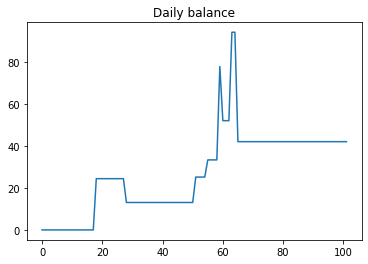

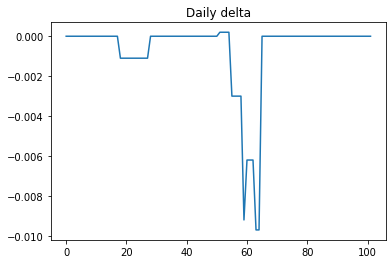

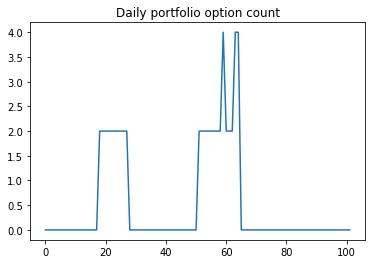

Elapsed time 3.234375 seconds
Short strangle2


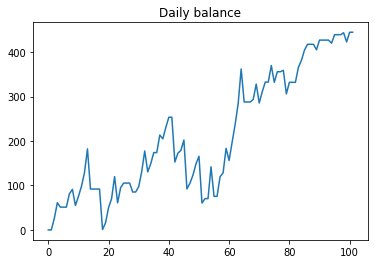

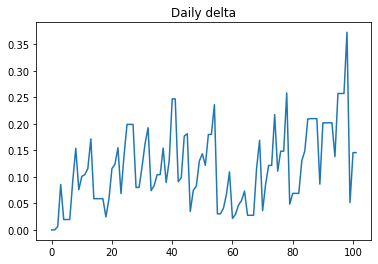

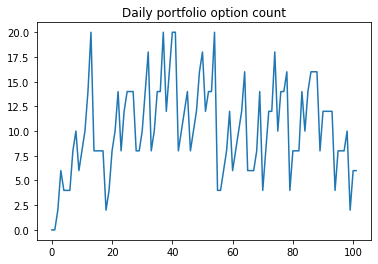

Elapsed time 3.09375 seconds
Short strangle3


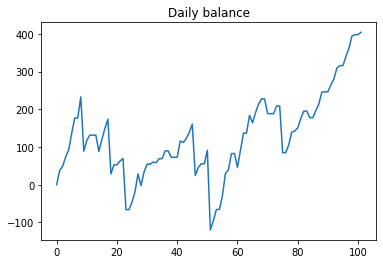

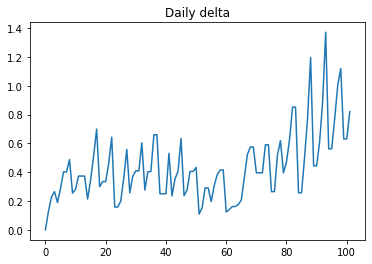

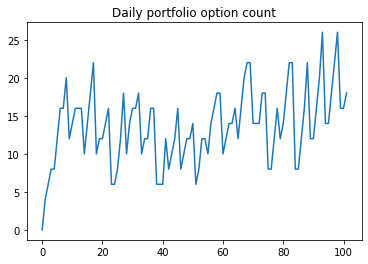

Elapsed time 4.53125 seconds
Short straddle


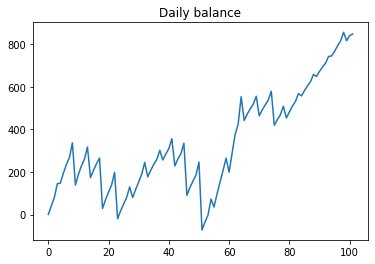

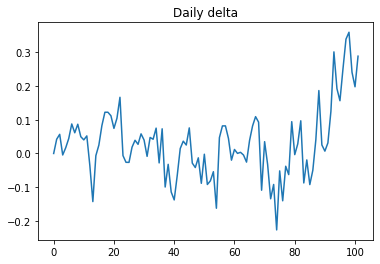

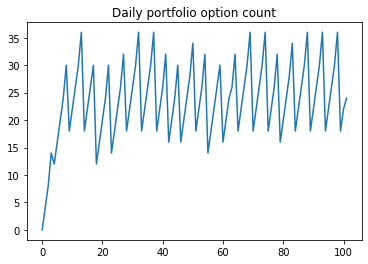

Elapsed time 1.859375 seconds


In [78]:
#assets = ['AMZN', 'GOOGL', 'NFLX', 'MSFT', 'FB', 'BA']
assets = ['AMZN']
for asset_name in assets:
    loader = cf.DataLoader(asset_name)
    loader.load()
    print(f"Simple simulation for {asset_name}")
    print("Short strangle")
    ShortStrangle(loader, asset_name).simulate()
    print("Short strangle2")
    ShortStrangle2(loader, asset_name).simulate()
    print("Short strangle3")
    ShortStrangle3(loader, asset_name).simulate()
    print("Short straddle")
    ShortStraddle(loader, asset_name).simulate()

